# EGCI 425 - Step 2: Data Preprocessing

**Objectives:**
1. Handle missing values
2. Handle outliers using Winsorization
3. Feature scaling/normalization
4. Create clean dataset for classification
5. Export preprocessed data

**Based on Step 1 findings:**
- Missing values: Aggregate Followers (15%), Screens (4%), Budget (0.4%)
- Target variable: Ratings (continuous)
- Top correlations: Gross (0.34), Budget (0.29)
- Significant outliers in: Budget, Gross, Views, Likes, Comments, Aggregate Followers

---
## 1. Import Libraries and Load Data

In [24]:
# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.impute import SimpleImputer
from scipy import stats

# Settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.2f}'.format)

print("Libraries imported successfully!")

Libraries imported successfully!


In [44]:
# Load the original dataset
file_path = 'dataset/2014 and 2015 CSM dataset.xlsx'

df_original = pd.read_excel(file_path)

df = df_original.copy()

print(f"Dataset loaded successfully!")
print(f"Shape: {df.shape[0]} rows × {df.shape[1]} columns")
print("\nFirst few rows:")
df.head()

Dataset loaded successfully!
Shape: 231 rows × 14 columns

First few rows:


,Movie,Year,Ratings,Genre,Gross,Budget,Screens,Sequel,Sentiment,Views,Likes,Dislikes,Comments,Aggregate Followers
0,13 Sins,2014,6.30,8,9130,4000000.00,45.00,1,0,3280543,4632,425,636,1120000.00
1,22 Jump Street,2014,7.10,1,192000000,50000000.00,3306.00,2,2,583289,3465,61,186,12350000.00
2,3 Days to Kill,2014,6.20,1,30700000,28000000.00,2872.00,1,0,304861,328,34,47,483000.00
3,300: Rise of an Empire,2014,6.30,1,106000000,110000000.00,3470.00,2,0,452917,2429,132,590,568000.00
4,A Haunted House 2,2014,4.70,8,17300000,3500000.00,2310.00,2,0,3145573,12163,610,1082,1923800.00


---
## 2. Review Data Quality Issues

In [26]:
# Check current state
print("CURRENT DATA QUALITY STATUS\n")

print("\n1. MISSING VALUES:")
missing_summary = pd.DataFrame({
    'Missing Count': df.isnull().sum(),
    'Missing %': (df.isnull().sum() / len(df)) * 100
})
missing_summary = missing_summary[missing_summary['Missing Count'] > 0].sort_values('Missing Count', ascending=False)
print(missing_summary)

print("\n2. DATA TYPES:")
print(df.dtypes)

print("\n3. BASIC STATISTICS:")
print(df.describe())

CURRENT DATA QUALITY STATUS


1. MISSING VALUES:
                     Missing Count  Missing %
Aggregate Followers             35      15.15
Screens                         10       4.33
Budget                           1       0.43

2. DATA TYPES:
Movie                   object
Year                     int64
Ratings                float64
Genre                    int64
Gross                    int64
Budget                 float64
Screens                float64
Sequel                   int64
Sentiment                int64
Views                    int64
Likes                    int64
Dislikes                 int64
Comments                 int64
Aggregate Followers    float64
dtype: object

3. BASIC STATISTICS:
         Year  Ratings  Genre        Gross       Budget  Screens  Sequel  \
count  231.00   231.00 231.00       231.00       230.00   221.00  231.00   
mean  2014.29     6.44   5.36  68066033.20  47921730.05  2209.24    1.36   
std      0.46     0.99   4.14  88902891.22  54288246.

---
## 3. Handle Missing Values

- **Budget (0.4% missing):** Impute with median (only 1 value missing)
- **Screens (4% missing):** Impute with median
- **Aggregate Followers (15% missing):** Impute with median

In [28]:
print("HANDLING MISSING VALUES\n")

# Store original counts for comparison
original_missing = df.isnull().sum().sum()

print("\n1. Budget - Imputing with MEDIAN")
budget_median = df['Budget'].median()
print(f"   Median value: ${budget_median:,.2f}")
print(f"   Missing before: {df['Budget'].isnull().sum()}")
df['Budget'].fillna(budget_median, inplace=True)
print(f"   Missing after: {df['Budget'].isnull().sum()}")

print("\n2. Screens - Imputing with MEDIAN")
screens_median = df['Screens'].median()
print(f"   Median value: {screens_median:,.0f}")
print(f"   Missing before: {df['Screens'].isnull().sum()}")
df['Screens'].fillna(screens_median, inplace=True)
print(f"   Missing after: {df['Screens'].isnull().sum()}")

print("\n3. Aggregate Followers - Imputing with MEDIAN")
followers_median = df['Aggregate Followers'].median()
print(f"   Median value: {followers_median:,.0f}")
print(f"   Missing before: {df['Aggregate Followers'].isnull().sum()}")
df['Aggregate Followers'].fillna(followers_median, inplace=True)
print(f"   Missing after: {df['Aggregate Followers'].isnull().sum()}")

# Final check
final_missing = df.isnull().sum().sum()
print("\n" + "="*60)
print(f"TOTAL MISSING VALUES: {original_missing} → {final_missing}")
print("="*60)

HANDLING MISSING VALUES


1. Budget - Imputing with MEDIAN
   Median value: $28,000,000.00
   Missing before: 0
   Missing after: 0

2. Screens - Imputing with MEDIAN
   Median value: 2,777
   Missing before: 0
   Missing after: 0

3. Aggregate Followers - Imputing with MEDIAN
   Median value: 1,052,600
   Missing before: 0
   Missing after: 0

TOTAL MISSING VALUES: 0 → 0


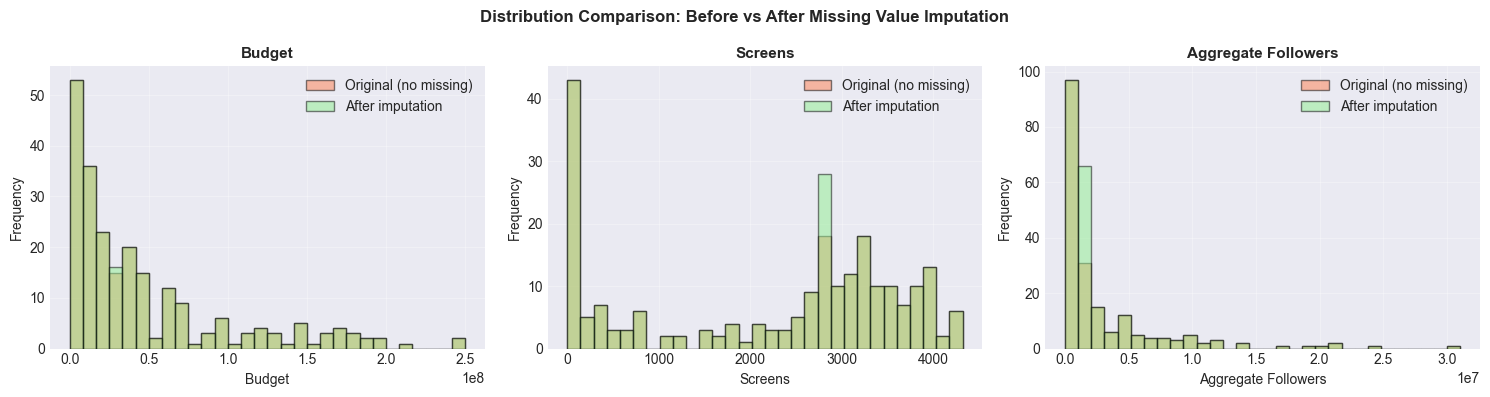

In [29]:
# Visualize missing value handling
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

features_with_missing = ['Budget', 'Screens', 'Aggregate Followers']

for idx, feature in enumerate(features_with_missing):
    # Compare distributions before and after imputation
    axes[idx].hist(df_original[feature].dropna(), bins=30, alpha=0.5, 
                   label='Original (no missing)', color='coral', edgecolor='black')
    axes[idx].hist(df[feature], bins=30, alpha=0.5, 
                   label='After imputation', color='lightgreen', edgecolor='black')
    axes[idx].set_title(f'{feature}', fontsize=11, fontweight='bold')
    axes[idx].set_xlabel(feature)
    axes[idx].set_ylabel('Frequency')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

plt.suptitle('Distribution Comparison: Before vs After Missing Value Imputation', 
             fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

---
## 4. Outlier Detection

In [30]:
# Detect outliers using IQR method
print("OUTLIER DETECTION (IQR Method)\n")

outlier_features = ['Budget', 'Gross', 'Screens', 'Views', 'Likes', 'Comments', 'Aggregate Followers']
outlier_summary = []

for feature in outlier_features:
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers_mask = (df[feature] < lower_bound) | (df[feature] > upper_bound)
    n_outliers = outliers_mask.sum()
    
    outlier_summary.append({
        'Feature': feature,
        'Lower Bound': lower_bound,
        'Upper Bound': upper_bound,
        'Outliers Count': n_outliers,
        'Outliers %': (n_outliers / len(df)) * 100
    })

outlier_df = pd.DataFrame(outlier_summary)
print("\n" + outlier_df.to_string(index=False))

OUTLIER DETECTION (IQR Method)


            Feature   Lower Bound  Upper Bound  Outliers Count  Outliers %
             Budget  -75000000.00 149000000.00              21        9.09
              Gross -108275000.00 207925000.00              16        6.93
            Screens      -3592.25      7489.75               0        0.00
              Views   -6267814.25  12108495.75              10        4.33
              Likes     -18430.00     35454.00              15        6.49
           Comments      -2584.25      4969.75              18        7.79
Aggregate Followers   -3478250.00   6463750.00              30       12.99


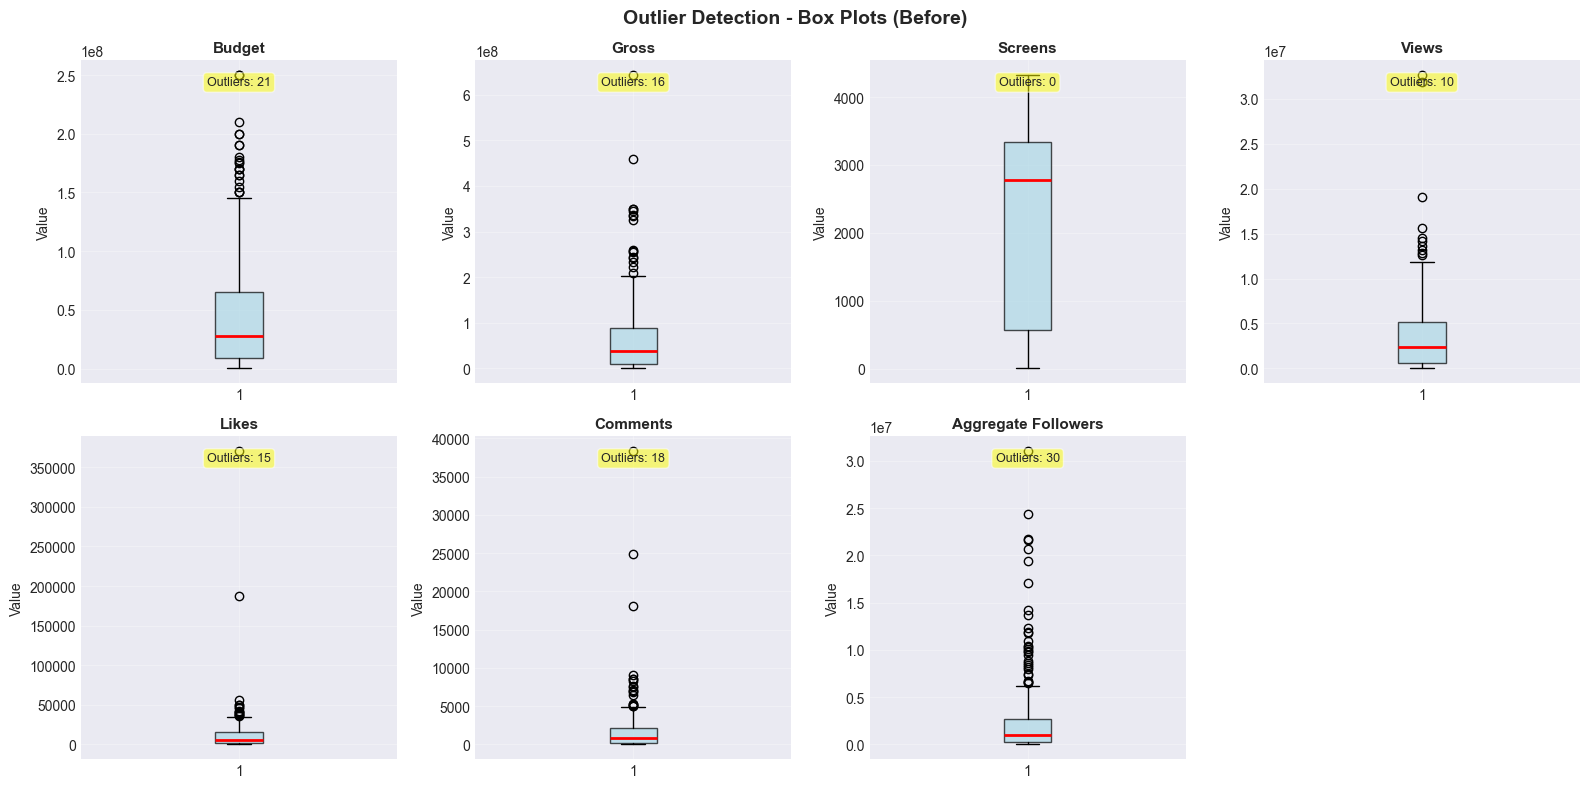

In [32]:
# Visualize outliers with box plots
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for idx, feature in enumerate(outlier_features):
    axes[idx].boxplot(df[feature], vert=True, patch_artist=True,
                      boxprops=dict(facecolor='lightblue', alpha=0.7),
                      medianprops=dict(color='red', linewidth=2))
    axes[idx].set_title(f'{feature}', fontsize=11, fontweight='bold')
    axes[idx].set_ylabel('Value')
    axes[idx].grid(True, alpha=0.3)
    
    # Add outlier count
    outlier_count = outlier_df[outlier_df['Feature'] == feature]['Outliers Count'].values[0]
    axes[idx].text(0.5, 0.95, f'Outliers: {outlier_count:.0f}',
                   transform=axes[idx].transAxes,
                   bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.5),
                   ha='center', va='top', fontsize=9)

axes[-1].axis('off')

plt.suptitle('Outlier Detection - Box Plots (Before)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

---
## 5. Outlier Handling - Winsorization

**Method:** Winsorization (Capping)
- Cap outliers at 1st and 99th percentiles
- Preserves all data points
- Reduces impact of extreme values
- Good for both tree-based and distance-based classifiers

In [33]:
print("OUTLIER HANDLING - WINSORIZATION\n")

# Features to winsorize (those with significant outliers)
features_to_winsorize = ['Budget', 'Gross', 'Views', 'Likes', 'Comments', 'Aggregate Followers']

# Create a copy for comparison
df_before_winsor = df.copy()

# Apply winsorization (cap at 1st and 99th percentiles)
winsor_results = []

for feature in features_to_winsorize:
    # Calculate percentiles
    lower_percentile = df[feature].quantile(0.01)
    upper_percentile = df[feature].quantile(0.99)
    
    # Count outliers before
    outliers_before = ((df[feature] < lower_percentile) | 
                      (df[feature] > upper_percentile)).sum()
    
    # Apply winsorization
    df[feature] = df[feature].clip(lower=lower_percentile, upper=upper_percentile)
    
    # Count outliers after
    outliers_after = ((df[feature] < lower_percentile) | 
                     (df[feature] > upper_percentile)).sum()
    
    winsor_results.append({
        'Feature': feature,
        'Lower Bound (1%)': lower_percentile,
        'Upper Bound (99%)': upper_percentile,
        'Values Capped': outliers_before
    })
    
    print(f"\n{feature}:")
    print(f"  Lower bound (1%): {lower_percentile:,.2f}")
    print(f"  Upper bound (99%): {upper_percentile:,.2f}")
    print(f"  Values capped: {outliers_before}")

winsor_df = pd.DataFrame(winsor_results)

print("\nWINSORIZATION COMPLETED!")
print(f"\nTotal values capped: {winsor_df['Values Capped'].sum()}")
print(f"Percentage of data affected: {(winsor_df['Values Capped'].sum() / len(df)) * 100:.2f}%")

OUTLIER HANDLING - WINSORIZATION


Budget:
  Lower bound (1%): 160,000.00
  Upper bound (99%): 207,000,000.00
  Values capped: 6

Gross:
  Lower bound (1%): 5,990.00
  Upper bound (99%): 350,000,000.00
  Values capped: 5

Views:
  Lower bound (1%): 3,062.60
  Upper bound (99%): 17,993,514.50
  Values capped: 6

Likes:
  Lower bound (1%): 4.60
  Upper bound (99%): 54,201.30
  Values capped: 6

Comments:
  Lower bound (1%): 0.30
  Upper bound (99%): 15,389.60
  Values capped: 6

Aggregate Followers:
  Lower bound (1%): 2,133.70
  Upper bound (99%): 21,663,910.00
  Values capped: 6

WINSORIZATION COMPLETED!

Total values capped: 35
Percentage of data affected: 15.15%


C:\Users\gab26\AppData\Local\Temp\ipykernel_8840\2074218711.py:22: FutureWarning: Downcasting behavior in Series and DataFrame methods 'where', 'mask', and 'clip' is deprecated. In a future version this will not infer object dtypes or cast all-round floats to integers. Instead call result.infer_objects(copy=False) for object inference, or cast round floats explicitly. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[feature] = df[feature].clip(lower=lower_percentile, upper=upper_percentile)


In [ ]:
# Display winsorization summary table
print("\nWinsorization Summary:")
print(winsor_df.to_string(index=False))

---
## 6. Visualize Impact of Winsorization

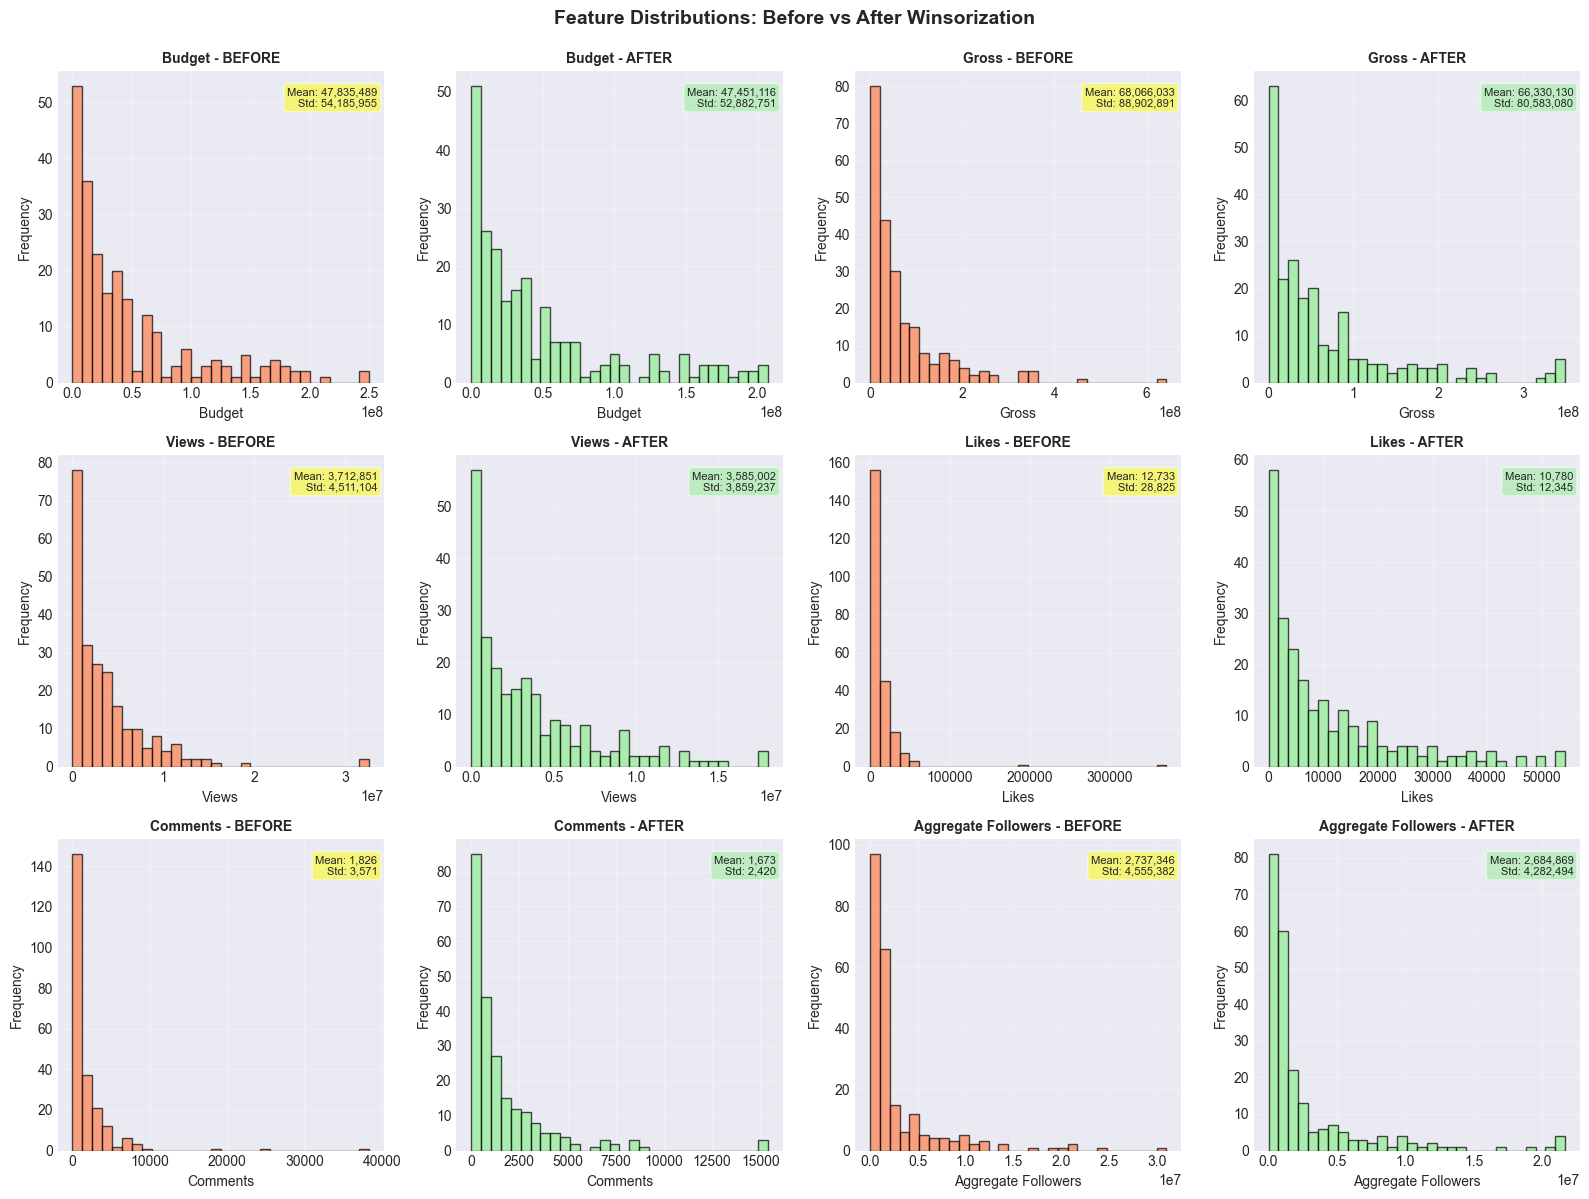

In [34]:
# Compare distributions before and after winsorization
fig, axes = plt.subplots(3, 4, figsize=(16, 12))
axes = axes.flatten()

for idx, feature in enumerate(features_to_winsorize):
    # Before winsorization
    axes[idx*2].hist(df_before_winsor[feature], bins=30, color='coral', 
                    edgecolor='black', alpha=0.7)
    axes[idx*2].set_title(f'{feature} - BEFORE', fontsize=10, fontweight='bold')
    axes[idx*2].set_xlabel(feature)
    axes[idx*2].set_ylabel('Frequency')
    axes[idx*2].grid(True, alpha=0.3)
    
    # Add stats
    mean_before = df_before_winsor[feature].mean()
    std_before = df_before_winsor[feature].std()
    axes[idx*2].text(0.98, 0.95, 
                    f'Mean: {mean_before:,.0f}\nStd: {std_before:,.0f}',
                    transform=axes[idx*2].transAxes,
                    bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.5),
                    ha='right', va='top', fontsize=8)
    
    # After winsorization
    axes[idx*2+1].hist(df[feature], bins=30, color='lightgreen', 
                      edgecolor='black', alpha=0.7)
    axes[idx*2+1].set_title(f'{feature} - AFTER', fontsize=10, fontweight='bold')
    axes[idx*2+1].set_xlabel(feature)
    axes[idx*2+1].set_ylabel('Frequency')
    axes[idx*2+1].grid(True, alpha=0.3)
    
    # Add stats
    mean_after = df[feature].mean()
    std_after = df[feature].std()
    axes[idx*2+1].text(0.98, 0.95, 
                      f'Mean: {mean_after:,.0f}\nStd: {std_after:,.0f}',
                      transform=axes[idx*2+1].transAxes,
                      bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.5),
                      ha='right', va='top', fontsize=8)

plt.suptitle('Feature Distributions: Before vs After Winsorization', 
             fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

C:\Users\gab26\AppData\Local\Temp\ipykernel_8840\554253524.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[idx].boxplot(data_to_plot,
C:\Users\gab26\AppData\Local\Temp\ipykernel_8840\554253524.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[idx].boxplot(data_to_plot,
C:\Users\gab26\AppData\Local\Temp\ipykernel_8840\554253524.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[idx].boxplot(data_to_plot,
C:\Users\gab26\AppData\Local\Temp\ipykernel_8840\554253524.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.

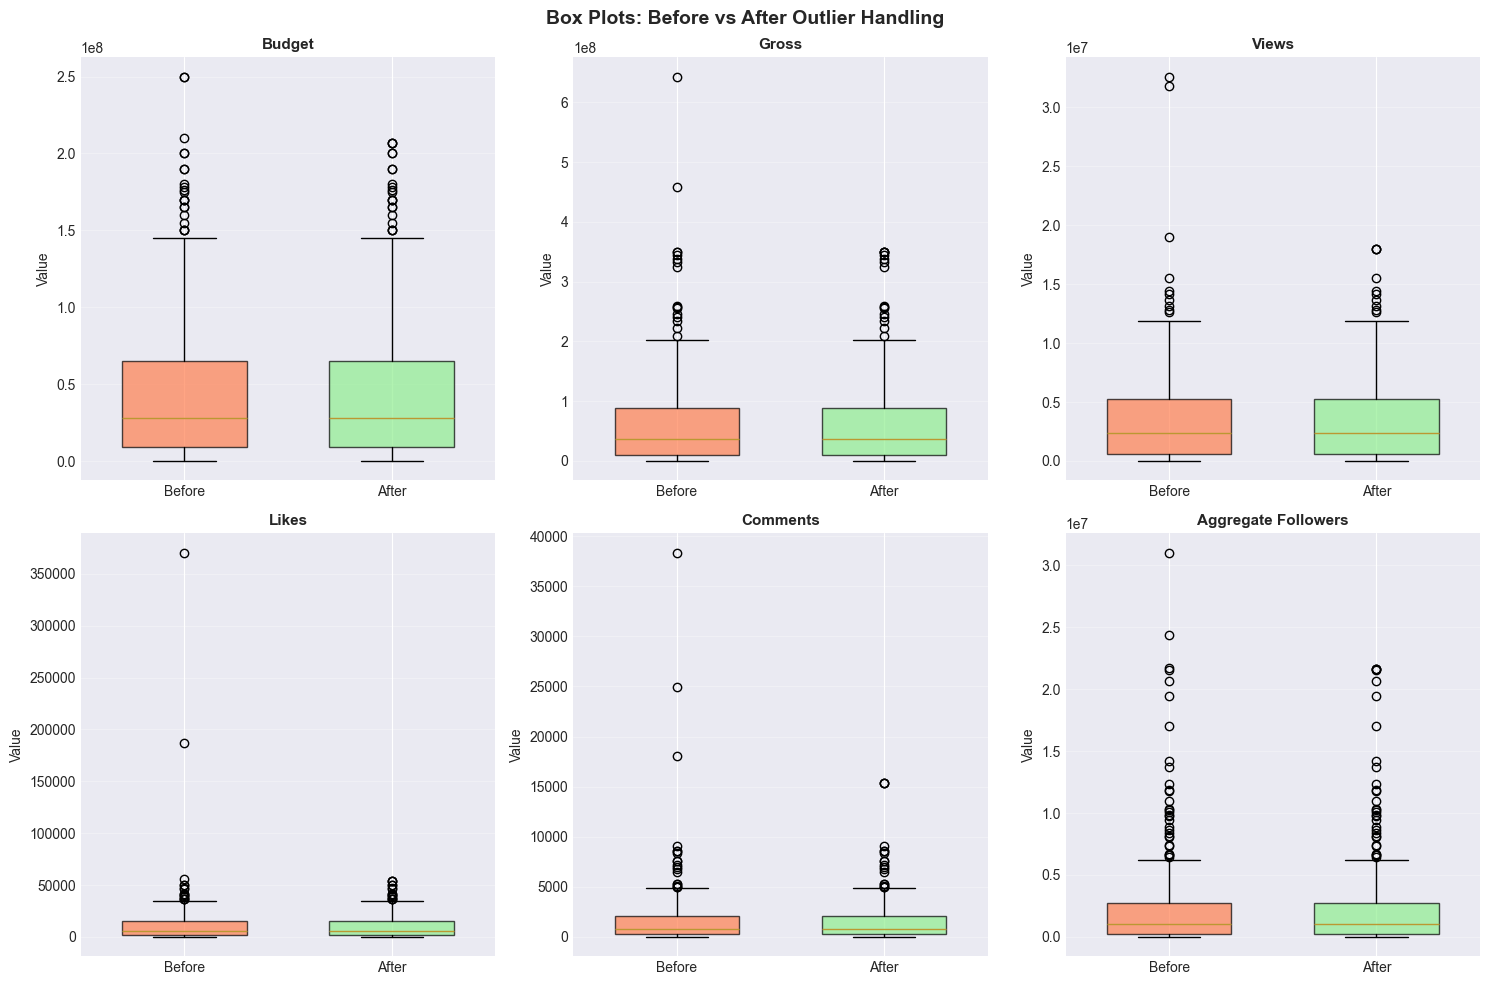

In [35]:
# Compare box plots before and after
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, feature in enumerate(features_to_winsorize):
    # Create side-by-side box plots
    data_to_plot = [df_before_winsor[feature], df[feature]]
    bp = axes[idx].boxplot(data_to_plot, 
                           labels=['Before', 'After'],
                           patch_artist=True,
                           widths=0.6)
    
    # Color the boxes
    bp['boxes'][0].set_facecolor('coral')
    bp['boxes'][0].set_alpha(0.7)
    bp['boxes'][1].set_facecolor('lightgreen')
    bp['boxes'][1].set_alpha(0.7)
    
    axes[idx].set_title(f'{feature}', fontsize=11, fontweight='bold')
    axes[idx].set_ylabel('Value')
    axes[idx].grid(True, alpha=0.3, axis='y')

plt.suptitle('Box Plots: Before vs After Outlier Handling', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

---
## 9. Feature Scaling

**Note:** 
- Tree-based methods (Decision Trees, Random Forest) don't need scaling
- Distance-based methods (SVM, KNN, Neural Networks) benefit from scaling

In [37]:
print("FEATURE SCALING\n")

# Identify numeric columns (exclude Movie and Ratings)
numeric_features = [col for col in numeric_cols if col not in ['Ratings']]

print(f"\nFeatures to scale: {len(numeric_features)}")
print(numeric_features)

# Create scaled version using StandardScaler
df_scaled = df.copy()
scaler = StandardScaler()

df_scaled[numeric_features] = scaler.fit_transform(df_scaled[numeric_features])

print("\nStandardScaler applied (mean=0, std=1)")
print("\nScaled data statistics:")
print(df_scaled[numeric_features].describe().loc[['mean', 'std']].round(3))

FEATURE SCALING


Features to scale: 12
['Year', 'Genre', 'Gross', 'Budget', 'Screens', 'Sequel', 'Sentiment', 'Views', 'Likes', 'Dislikes', 'Comments', 'Aggregate Followers']

StandardScaler applied (mean=0, std=1)

Scaled data statistics:
      Year  Genre  Gross  Budget  Screens  Sequel  Sentiment  Views  Likes  \
mean -0.00   0.00   0.00   -0.00    -0.00    0.00       0.00  -0.00   0.00   
std   1.00   1.00   1.00    1.00     1.00    1.00       1.00   1.00   1.00   

      Dislikes  Comments  Aggregate Followers  
mean     -0.00     -0.00                 0.00  
std       1.00      1.00                 1.00  


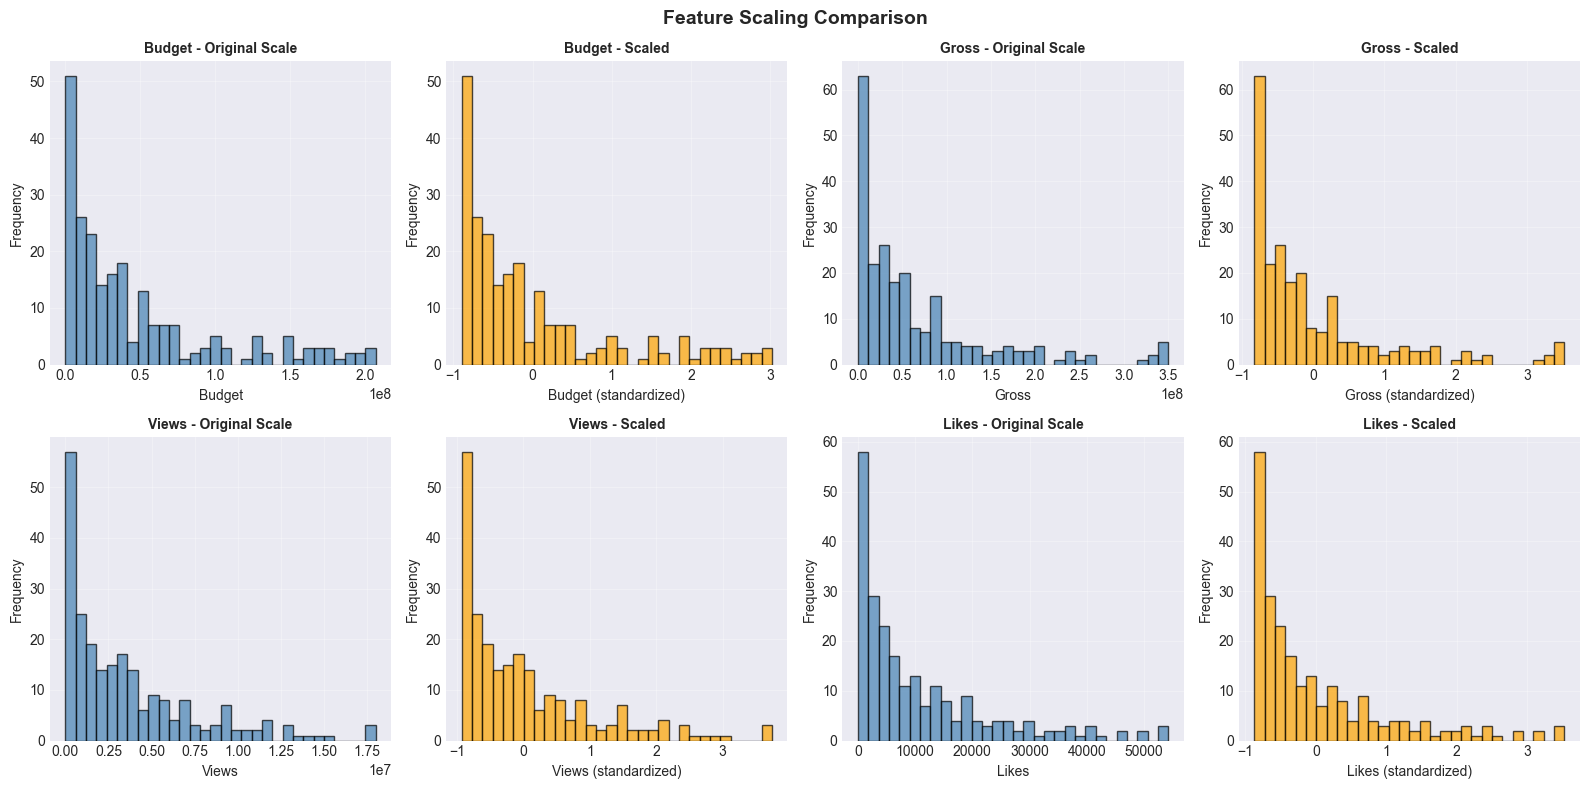

In [38]:
# Visualize scaling impact
sample_features = ['Budget', 'Gross', 'Views', 'Likes']

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for idx, feature in enumerate(sample_features):
    # Before scaling
    axes[idx*2].hist(df[feature], bins=30, color='steelblue', 
                    edgecolor='black', alpha=0.7)
    axes[idx*2].set_title(f'{feature} - Original Scale', fontsize=10, fontweight='bold')
    axes[idx*2].set_xlabel(feature)
    axes[idx*2].set_ylabel('Frequency')
    axes[idx*2].grid(True, alpha=0.3)
    
    # After scaling
    axes[idx*2+1].hist(df_scaled[feature], bins=30, color='orange', 
                      edgecolor='black', alpha=0.7)
    axes[idx*2+1].set_title(f'{feature} - Scaled', fontsize=10, fontweight='bold')
    axes[idx*2+1].set_xlabel(f'{feature} (standardized)')
    axes[idx*2+1].set_ylabel('Frequency')
    axes[idx*2+1].grid(True, alpha=0.3)

plt.suptitle('Feature Scaling Comparison', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

---
## 10. Prepare Final Datasets

In [40]:
print("PREPARING FINAL DATASETS FOR CLASSIFICATION\n")

# Version 1: Unscaled (for tree-based methods)
df_final = df.copy()
print(f"\n1. Unscaled Version:")
print(f"   Shape: {df_final.shape}")
print(f"   Missing values: {df_final.isnull().sum().sum()}")
print(f"   Best for: Decision Trees, Random Forest, Gradient Boosting")

# Version 2: Scaled (for distance-based methods)
df_final_scaled = df_scaled.copy()
print(f"\n2. Scaled Version:")
print(f"   Shape: {df_final_scaled.shape}")
print(f"   Missing values: {df_final_scaled.isnull().sum().sum()}")
print(f"   Best for: SVM, Neural Networks, KNN")

print("DATA QUALITY SUMMARY\n")
print(f" Total samples: {len(df_final)}")
print(f" Total features: {df_final.shape[1]}")
print(f" Missing values: 0")
print(f" Outliers: Handled via Winsorization")

PREPARING FINAL DATASETS FOR CLASSIFICATION


1. Unscaled Version:
   Shape: (231, 14)
   Missing values: 0
   Best for: Decision Trees, Random Forest, Gradient Boosting

2. Scaled Version:
   Shape: (231, 14)
   Missing values: 0
   Best for: SVM, Neural Networks, KNN
DATA QUALITY SUMMARY

 Total samples: 231
 Total features: 14
 Missing values: 0
 Outliers: Handled via Winsorization


---
## 11. Export Preprocessed Datasets

In [43]:
print("EXPORTING PREPROCESSED DATASETS\n")

# Export unscaled version
df_final.to_csv('step2_preprocessed_data.csv', index=False)
print("\n Saved: step2_preprocessed_data.csv")
print("   - Missing values: Handled")
print("   - Outliers: Winsorized")
print("   - Scaling: No")
print("   - Use for: Tree-based classifiers")

# Export scaled version
df_final_scaled.to_csv('step2_preprocessed_data_scaled.csv', index=False)
print("\n Saved: step2_preprocessed_data_scaled.csv")
print("   - Missing values: Handled")
print("   - Outliers: Winsorized")
print("   - Scaling: Yes (StandardScaler)")
print("   - Use for: SVM, Neural Networks, KNN")


print("\nALL FILES EXPORTED SUCCESSFULLY!")

EXPORTING PREPROCESSED DATASETS


 Saved: step2_preprocessed_data.csv
   - Missing values: Handled
   - Outliers: Winsorized
   - Scaling: No
   - Use for: Tree-based classifiers

 Saved: step2_preprocessed_data_scaled.csv
   - Missing values: Handled
   - Outliers: Winsorized
   - Scaling: Yes (StandardScaler)
   - Use for: SVM, Neural Networks, KNN

Saved: step2_preprocessing_summary.json

ALL FILES EXPORTED SUCCESSFULLY!
